# Table of Contents 

- [DBSCAN parameters tunning](#dbscan-parameter-tunning)
- [Clustering exercise: Color compression](#exercise-color-compression)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
%matplotlib inline

# DBSCAN parameters tunning

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

### Task: Apply it to the toy datasets, how do you tune the parameters? Comment the results

Dataset: Toy Dataset

---


This dataset doesn't have too much noise so identifying the "eps" values is not difficult if we plot the reachability distance for each point. We identified two possible values for "eps" by drawing lines which cut the **valleys**. By using the **OPTICS** fit results, we executed DBSCAN with the two eps candidates values.

labels dbscan config 2 - Counter({np.int64(0): 25, np.int64(3): 25, np.int64(1): 24, np.int64(2): 23, np.int64(-1): 3})


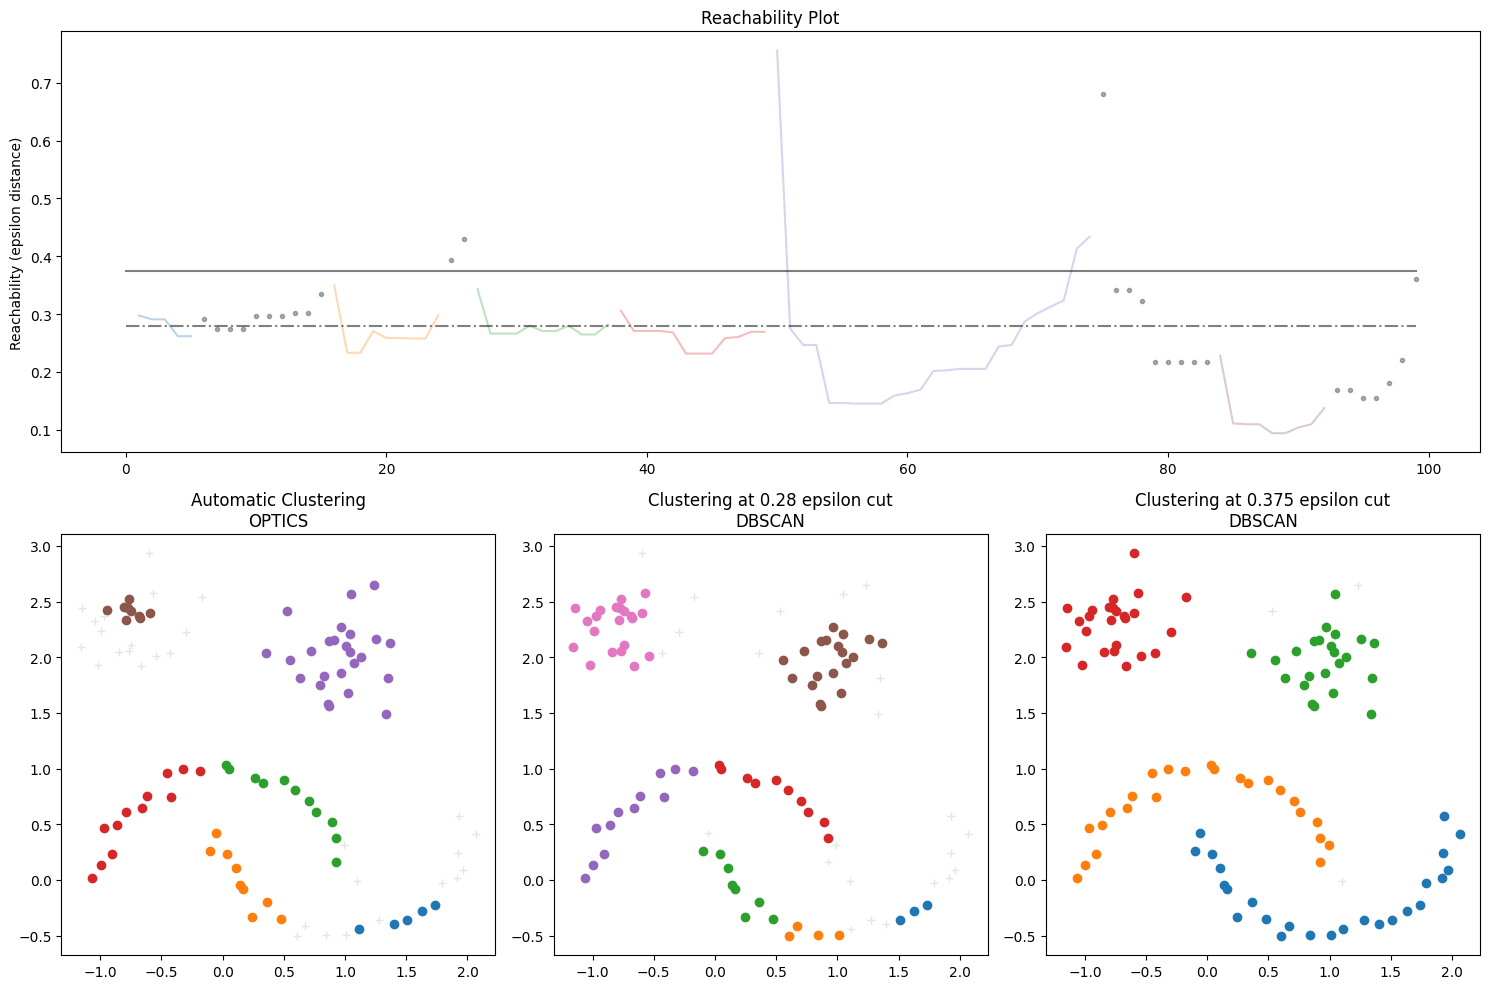

In [23]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
from itertools import cycle
from collections import Counter
import sklearn.datasets as data

moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1_path = './clusterable_data.npy'
test_data_1 = np.load(test_data_1_path)

cycol = cycle('bgrcmk')

# (1) computing reachability distance
X = test_data_0
clust = OPTICS(min_samples = 5).fit(X)

# the reachability plot gives us an 
eps_1 = 0.28
eps_2 = 0.375

labels_eps_1 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=eps_1)
labels_eps_2 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=eps_2)

plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]
space = np.arange(len(X))

# (2) Reachability plot
for i, klass in enumerate(set(clust.labels_)):
    if (klass == -1): continue
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk ,alpha=0.3)

ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, eps_1, dtype=float), 'k-.', alpha=0.5)
ax1.plot(space, np.full_like(space, eps_2, dtype=float), 'k-', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# (3) OPTICS
for i, klass in enumerate(set(clust.labels_)):
    if (klass == -1): continue
    Xk = X[clust.labels_ == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1])
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# (4) DBSCAN, epison = eps_1
for i, klass in enumerate(set(labels_eps_1)):
    if (klass == -1): continue
    Xk = X[labels_eps_1 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1])
ax3.plot(X[labels_eps_1 == -1, 0], X[labels_eps_1 == -1, 1], 'k+', alpha=0.1)
ax3.set_title(f'Clustering at {eps_1} epsilon cut\nDBSCAN')

# (5) DBSCAN, epison = eps_2
for i, klass in enumerate(set(labels_eps_2)):
    if (klass == -1): continue
    Xk = X[labels_eps_2 == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1])
ax4.plot(X[labels_eps_2 == -1, 0], X[labels_eps_2 == -1, 1], 'k+', alpha=0.1)
ax4.set_title(f'Clustering at {eps_2} epsilon cut\nDBSCAN')

print(f'labels dbscan config 2 - {Counter(labels_eps_2)}')

plt.tight_layout()
plt.show()

Dataset: Noised Toy Dataset

---

For this dataset, we are going to generate K-dist plots to identify possible **eps** values with different combinations of **minpts** values. K-dist plots are going to be generated by using **mintps** values from 5 to 20.

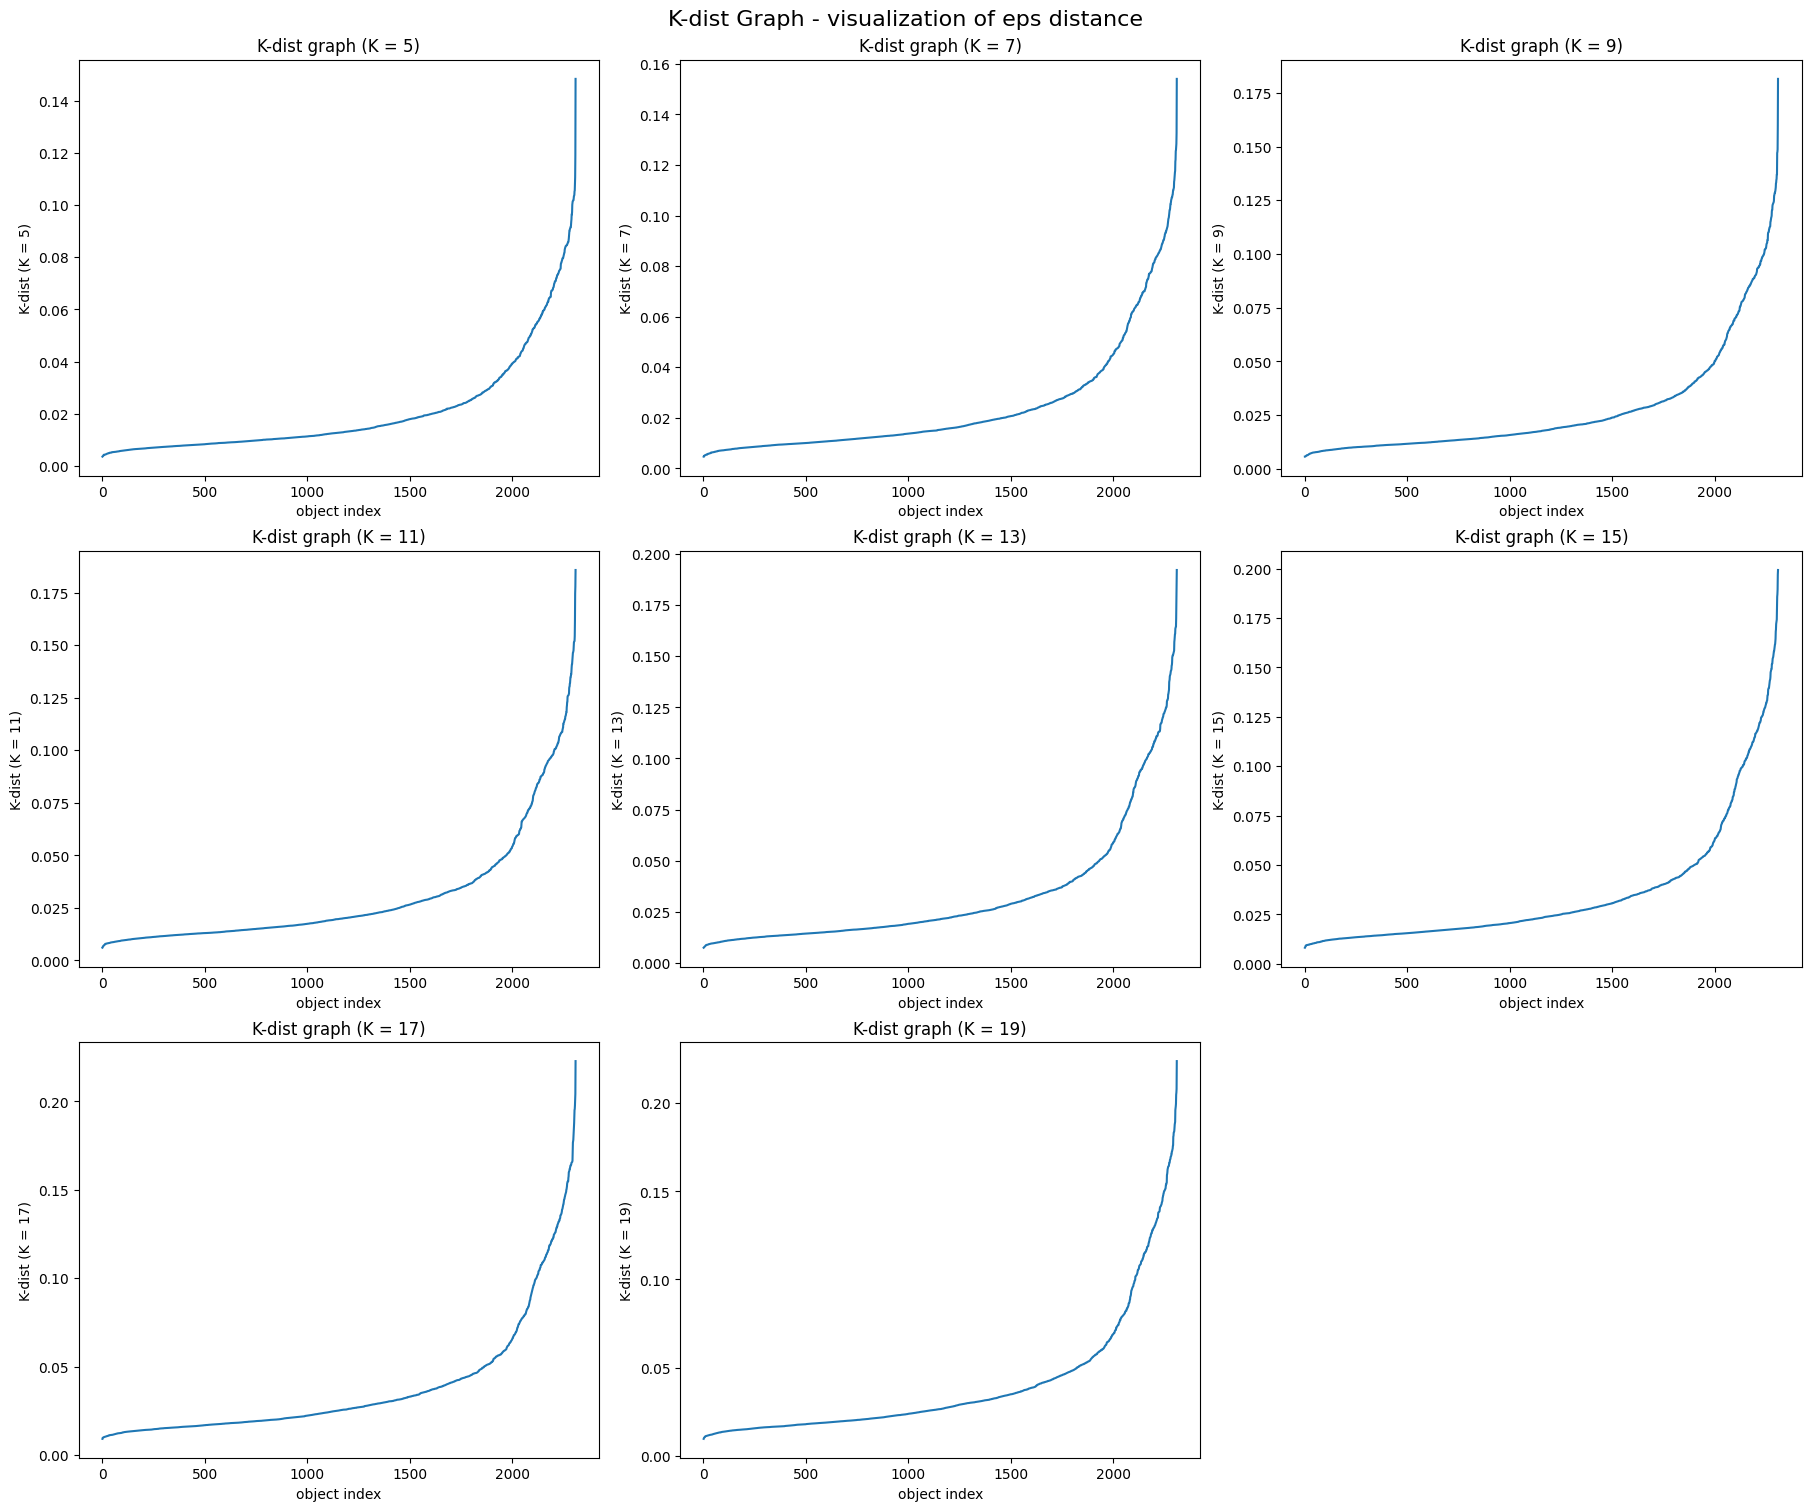

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import VALID_METRICS
import sklearn
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib import pyplot as plt
import math

X = test_data_1

start_min_pts = 5
end_min_pts = 20
steps_min_pts = 2
metric = 'euclidean'
fig_width = 6
fig_height = 5
ncols = 3
minpts_list = range(start_min_pts, end_min_pts + 1, steps_min_pts)
nrows = math.ceil(len(minpts_list) * 1.0 / ncols)
fig, plots = plt.subplots(nrows= nrows, ncols= ncols, figsize=(fig_width * ncols,  nrows * fig_height), constrained_layout=True)
fig.suptitle('K-dist Graph - visualization of eps distance', fontsize=16)
for row in plots:
    for col in row:
        col.set_visible(False)
for i in range(len(minpts_list)):
    k = minpts_list[i]
    # +1 because the NN considers the current point as in its neighbor
    nn_method = NearestNeighbors(n_neighbors= k + 1, metric = metric).fit(X)
    distances, indexes = nn_method.kneighbors(X)
    distance_k_point = [x[-1] for x in distances]
    arr = np.asarray(distance_k_point).reshape(-1, 1)
    i_row = math.floor(i / ncols)
    i_col = i - i_row * ncols
    plt = plots[i_row][i_col]
    distance_k_point = sorted(distance_k_point, reverse=False)
    plt.plot(range(1, len(distance_k_point) + 1), distance_k_point)
    plt.set_visible(True)
    plt.set_xlabel('object index')
    plt.set_ylabel(f"K-dist (K = {k})") 
    plt.title.set_text(f'K-dist graph (K = {k})')

Counter({np.int64(2): 600, np.int64(0): 420, np.int64(-1): 419, np.int64(6): 337, np.int64(5): 302, np.int64(4): 205, np.int64(3): 11, np.int64(1): 8, np.int64(7): 7})


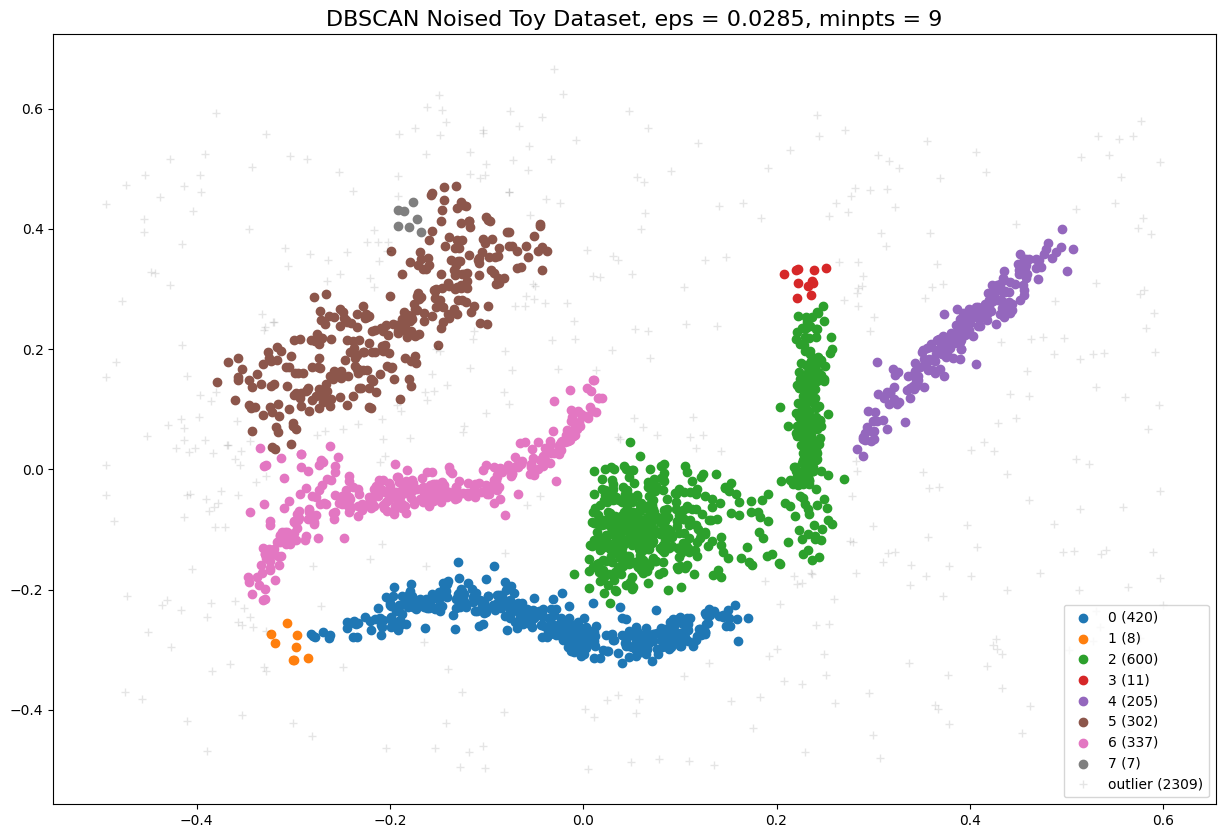

In [14]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import Counter

X = test_data_1
eps = 0.0285
minpts = 9
clustering = DBSCAN(eps = eps, min_samples = minpts).fit(X)

counter = Counter(clustering.labels_)
print(counter)

unique_labels = list(set(clustering.labels_))
plt.figure(figsize=(15, 10))

for i, klass in enumerate(set(unique_labels)):
    if (klass == -1): continue
    Xk = X[clustering.labels_ == klass]
    plt.scatter(Xk[:, 0], Xk[:, 1], label = f"{klass} ({len(Xk)})")
plt.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], 'k+', alpha=0.1, label = f"outlier ({len(clustering.labels_ == -1)})")
plt.legend(loc = 'lower right')
plt.title(f'DBSCAN Noised Toy Dataset, eps = {eps}, minpts = {minpts}', size=16)
plt.show()

# Clustering exercise: Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.
Get a simplified colored version of the following image by applying a clustering algorithm:

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
<class 'PIL.JpegImagePlugin.JpegImageFile'>
(561, 427, 3)
<class 'numpy.uint8'>


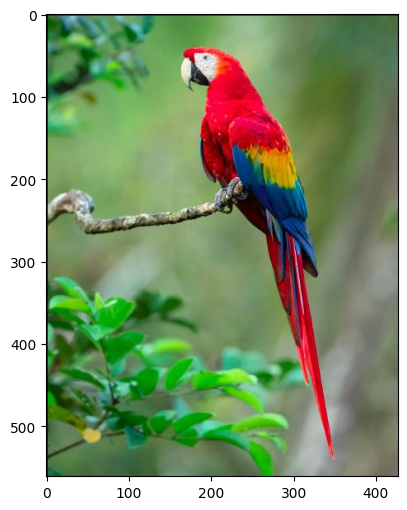

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

image_file = "parrot_guacamayo.jpg"
image_object = Image.open(image_file)
print(type(image_object))
image_bytes = np.asarray(image_object)
print(image_bytes.shape)
fig = plt.figure(figsize=(8, 6))
plt.imshow(image_bytes)
print(type(image_bytes[0][0][0]))

In [20]:
# TODO
# scale to 0->1
image_scaled_bytes = np.array(image_bytes, dtype=np.float64) / 255
# reshape 
w, h, d = tuple(image_scaled_bytes.shape)
print(f'w {w} h {h} d {d}')
image_scaled_array = np.reshape(image_scaled_bytes, (w * h, d))

w 561 h 427 d 3


## Task: Apply clustering methods on the colors of the image to generated a 16-color version. 
For each cluster of colors you can assign a new color corresponding to the color vector of the center of the cluster. The sklearn kmeans can provide the center of each cluster with the attributes cluster_centers_. Show the compressed picture.

Text(0.5, 1.0, '16-color Image')

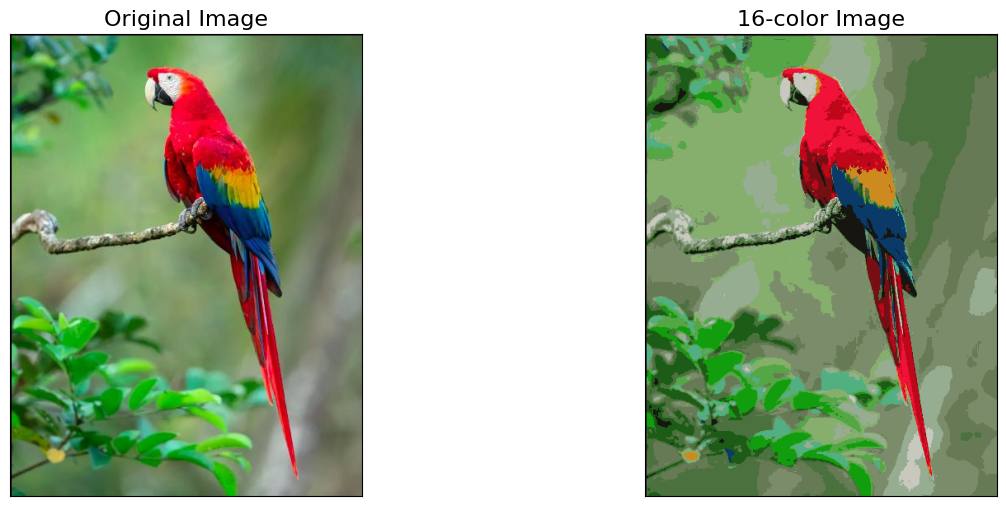

In [22]:
from sklearn.cluster import KMeans
from PIL import Image

##TODO  
n_colors = 16

# (1) for each pixel we assign the centroid-pixel computed for each cluster

# (2) reshape


fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image_bytes)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(parrot_recolored_3d)
ax[1].set_title('16-color Image', size=16)